### Import libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

/Users/ericwu1/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ericwu1/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Processing

In [3]:
# Download the dataset and load the data
path = kagglehub.dataset_download("joebeachcapital/maternal-health-risk")
df = pd.read_csv(f'{path}/Maternal Health Risk Data Set.csv')
print(df.head())
print(df.shape)

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
(1014, 7)


In [4]:
# Check if there are null values for the dataset
print(df.isnull().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [5]:
# Check duplicates
print(df.duplicated().sum())

562


In [6]:
# Remove Duplicates
df = df.drop_duplicates()

In [7]:
# Check Null value
print(df.isnull().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [8]:
# Check the distribution of label data to see if it is balanced
print(df["RiskLevel"].value_counts())

RiskLevel
low risk     234
high risk    112
mid risk     106
Name: count, dtype: int64


<Axes: >

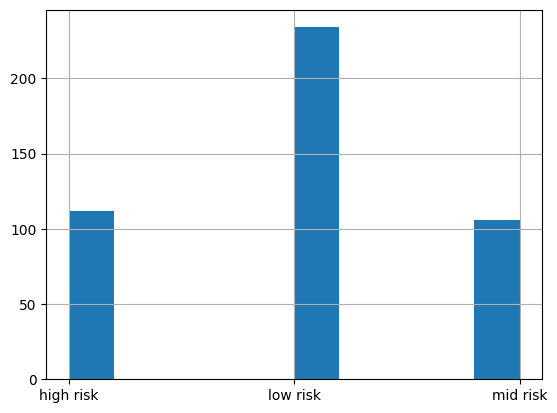

In [9]:
df["RiskLevel"].hist()

/var/folders/s1/288hxdd575x_j69mxzxysh9m0000gn/T/ipykernel_67310/2855481771.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SystolicBP'}>],
       [<Axes: title={'center': 'DiastolicBP'}>,
        <Axes: title={'center': 'BS'}>],
       [<Axes: title={'center': 'BodyTemp'}>,
        <Axes: title={'center': 'HeartRate'}>]], dtype=object)

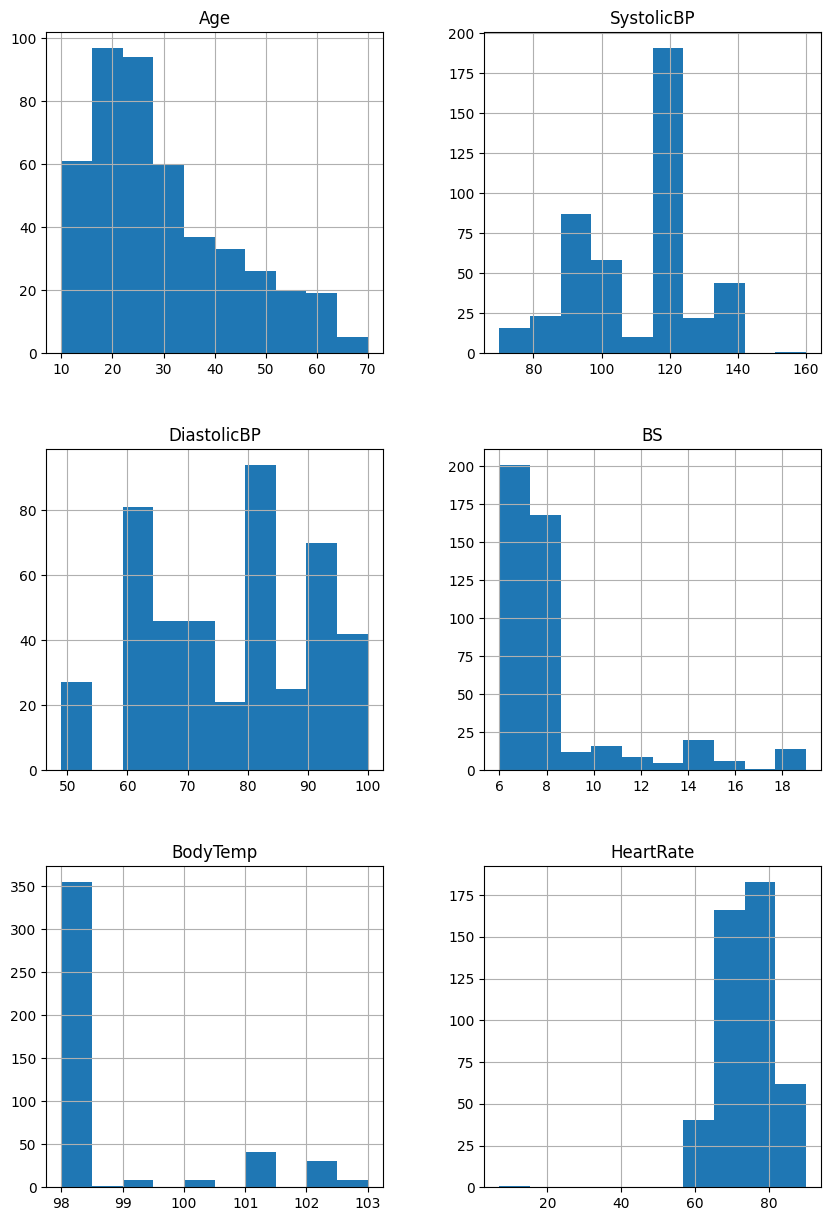

In [11]:
fig = plt.figure(figsize = (10,15))
ax = fig.gca()
df.hist(ax = ax)

# hist = df.hist(bins=20)

## Model 1 - Logistic Regression

In [239]:
# Create features and label data X, y
X = df.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df["RiskLevel"].map(label_map)
y = tf.keras.utils.to_categorical(y)
print(X.shape)
print(y.shape)

(452, 6)
(452, 3)


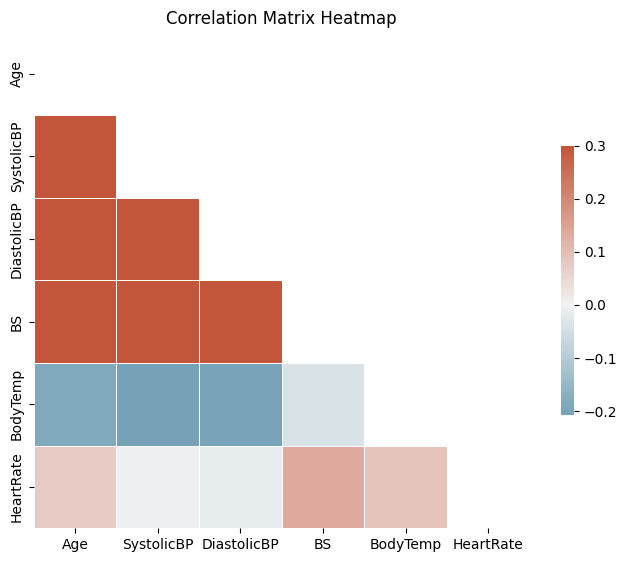

In [240]:
# Plot Correlation Matrix Heatmap

# df["RiskLevel"] = df["RiskLevel"].map(label_map)
corr = X.corr()
# Create for the upper triangle (remove the same corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap', fontsize=12)
plt.show()

In [241]:
# Create training data, validation data, and testing data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(271, 6) (90, 6) (91, 6) (271, 3) (90, 3) (91, 3)


In [242]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val) 
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(271, 6) (91, 6) (271, 3) (91, 3)


In [243]:
# Define model
model = tf.keras.Sequential(
    [
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(
        units = 3,
        use_bias=True,
        activation="softmax",
        kernel_initializer='ones',  
        bias_initializer='ones',     
        )
    ]
)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history_lr = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=0)
# print last accuracy, loss for training and validation
print("Last training accuracy:", round(history_lr.history["accuracy"][-1], 4))
print("Last validation accuracy:", round(history_lr.history["val_accuracy"][-1],4))
print("Last training loss:", round(history_lr.history["loss"][-1], 4))
print("Last validation loss:", round(history_lr.history["val_loss"][-1], 4))


Last training accuracy: 0.6494
Last validation accuracy: 0.5889
Last training loss: 0.8396
Last validation loss: 0.8788


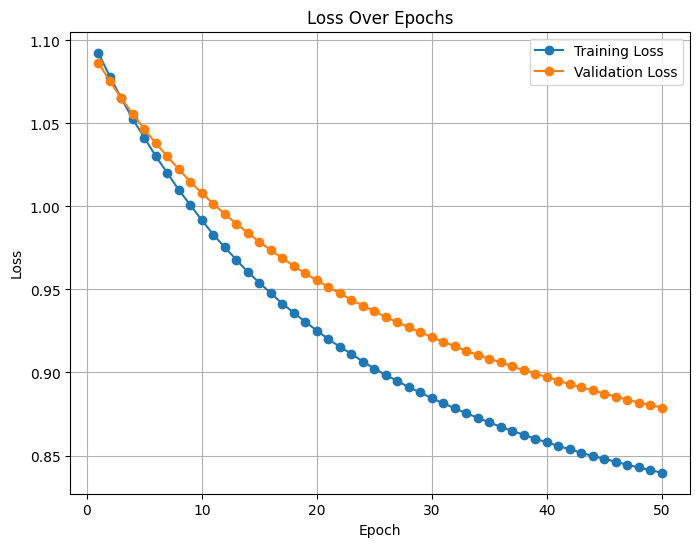

In [244]:
# Plot the losses
plt.figure(figsize=(8, 6))
epochs = range(1, len(history_lr.history['loss']) + 1)
plt.plot(epochs, history_lr.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history_lr.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [245]:
# Hyperparameter Tuning, try different epochs and batch_sizes and print out results
def experiment_parameters(epochs_list, batch_sizes_list):
    results = []
    for ep in epochs_list:
        for bs in batch_sizes_list:
            print(f"Training with epochs={ep}, batch_size={bs} ...")

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=ep,
                batch_size=bs,
                validation_data=(X_val, y_val),
                verbose=0 
            )
            
            # Extract the last training/validation loss and accuracy
            train_loss = history.history["loss"][-1]
            train_acc = history.history["accuracy"][-1]
            val_loss = history.history["val_loss"][-1]
            val_acc = history.history["val_accuracy"][-1]
            
            # Store the results
            results.append({
                "Epochs": ep,
                "Batch Size": bs,
                "Train Accuracy": round(train_acc, 4),
                "Val Accuracy": round(val_acc, 4),
                "Train Loss": round(train_loss, 4),
                "Val Loss": round(val_loss, 4),
            })
            
    # Convert to a DataFrame for easy viewing
    df_results = pd.DataFrame(results)
    print(df_results)
# Set parameters
epochs_list=[10, 20, 50, 100]
batch_sizes_list=[16, 32, 64, 128]
# Call function
experiment_parameters(epochs_list,  batch_sizes_list)




Training with epochs=10, batch_size=16 ...
Training with epochs=10, batch_size=32 ...
Training with epochs=10, batch_size=64 ...
Training with epochs=10, batch_size=128 ...
Training with epochs=20, batch_size=16 ...
Training with epochs=20, batch_size=32 ...
Training with epochs=20, batch_size=64 ...
Training with epochs=20, batch_size=128 ...
Training with epochs=50, batch_size=16 ...
Training with epochs=50, batch_size=32 ...
Training with epochs=50, batch_size=64 ...
Training with epochs=50, batch_size=128 ...
Training with epochs=100, batch_size=16 ...
Training with epochs=100, batch_size=32 ...
Training with epochs=100, batch_size=64 ...
Training with epochs=100, batch_size=128 ...
    Epochs  Batch Size  Train Accuracy  Val Accuracy  Train Loss  Val Loss
0       10          16          0.6347        0.5889      0.8191    0.8543
1       10          32          0.6421        0.5889      0.8111    0.8447
2       10          64          0.6384        0.6000      0.8074    0.8396
3   

In [246]:
# Pick the best parameters to build model_tuned
model_tuned = tf.keras.Sequential(
    [
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(
        units = 3,
        use_bias=True,
        activation="softmax",
        kernel_initializer='ones',  
        bias_initializer='ones',     
        )
    ]
)
# Compile the model
model_tuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
model_tuned.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=0)

In [247]:
# Get predictions on the training dataset
y_train_pred1 = model_tuned.predict(X_train)
y_train_pred_labels = np.argmax(y_train_pred1, axis=1)
# Get predictions on the test dataset 
y_test_pred = model_tuned.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Convert one-hot encoded y_train and y_test back to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute accuracy scores
train_accuracy = accuracy_score(y_train_labels, y_train_pred_labels)
test_accuracy = accuracy_score(y_test_labels, y_test_pred_labels)

# Display results
print("Train Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train Accuracy: 0.6384
Test Accuracy: 0.7253


## Model 2 - Decision Tree

In [248]:
# Import additional libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [249]:
# Create features and label data X, y
X = df.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df["RiskLevel"].map(label_map)
print(X.shape)
print(y.shape)

(452, 6)
(452,)


In [250]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=1234)
# Train the model
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=1234)

In [251]:
# Make predictions on the training dataset
y_train_pred = model.predict(X_train)

# Make predictions on the test dataset
y_test_pred = model.predict(X_test)

# Compute accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracy scores
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 0.9280
Test Accuracy: 0.6264


In [252]:
# Hypertune the model
# Define Parameter Grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10, None],  # None means no limit
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=1234)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,             # 5-fold cross-validation
    n_jobs=-1,        # use all available CPU cores
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Score (CV):", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Score (CV): 0.7449771689497717
Best Params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [253]:
best_model = grid_search.best_estimator_

# Check training accuracy
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Check test accuracy
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

Training Accuracy: 0.7839
Test Accuracy:     0.6703


## Model 3 - Random Forest

In [254]:
# Import additional libraries
from sklearn import ensemble

In [255]:
# Create features and label data X, y
X = df.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df["RiskLevel"].map(label_map)
print(X.shape)
print(y.shape)

(452, 6)
(452,)


In [256]:
# Create training data, validation data, and testing data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(316, 6) (68, 6) (68, 6) (316,) (68,) (68,)


In [257]:
# Initialize the RandomForestClassifier with given parameters
clf = ensemble.RandomForestClassifier(
    n_estimators=500,
    n_jobs=1,
    random_state=1234,
    max_depth=12
)
# Train the classifier
clf.fit(X_train, y_train)
# Predictions on training and validation sets
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
# Evaluate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
# Print results
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.9241
Validation Accuracy: 0.5441


Text(0.5, 1.0, 'Confusion Matrix')

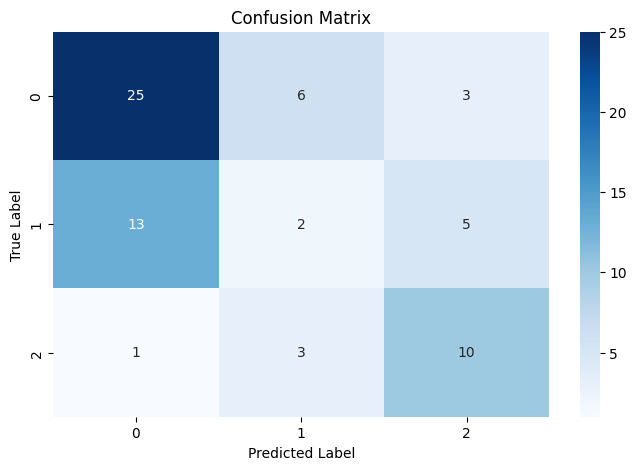

In [258]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [259]:
# Hypertune the model
# Initialize a RandomForestClassifier
rf = ensemble.RandomForestClassifier(random_state=1234)

# GridSearchCV with 3-fold cross-validation
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,   # use all CPU cores
    verbose=1
)

# Fit on the training set
grid.fit(X_train, y_train)

# Best parameters and best CV score
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Evaluate on validation set
best_model = grid.best_estimator_
y_val_pred = best_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.734261755016472
Validation Accuracy: 0.6912


Text(0.5, 1.0, 'Confusion Matrix')

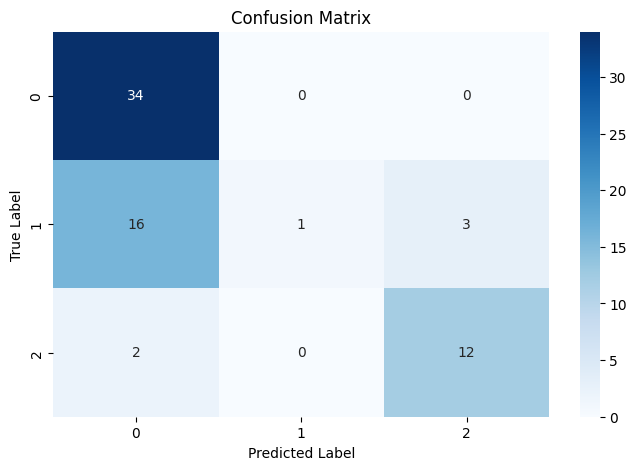

In [260]:
# Compute confusion matrix again
cm = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [261]:
# Check test accuracy
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

Training Accuracy: 0.7839
Test Accuracy:     0.7059


## Model 4 - Artificial Neural Networks

In [262]:
# Create features and label data X, y
X = df.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df["RiskLevel"].map(label_map)
print(X.shape)
print(y.shape)

(452, 6)
(452,)


In [263]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [264]:
# Initialize the ANN model
model = tf.keras.models.Sequential()

# Add the input layer and first hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
# Add dropout to reduce overfitting
model.add(tf.keras.layers.Dropout(0.3))

# Add a second hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

# Add the output layer (3 neurons for 3 classes and softmax activation)
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# Choose an optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

/Users/ericwu1/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627 (10.26 KB)

 Trainable params: 2,627 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

In [265]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=0
)

# print last accuracy, loss for training and validation
print("Last training accuracy:", round(history.history["accuracy"][-1], 4))
print("Last validation accuracy:", round(history.history["val_accuracy"][-1],4))
print("Last training loss:", round(history.history["loss"][-1], 4))
print("Last validation loss:", round(history.history["val_loss"][-1], 4))

Last training accuracy: 0.7778
Last validation accuracy: 0.726
Last training loss: 0.5849
Last validation loss: 0.6766


In [266]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {loss:.4f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.7123 
Test Accuracy: 0.6484
Test Loss: 0.7297


In [267]:
# Hypertune the model
def experiment_parameters(epochs_list, batch_sizes_list):
    results = []
    for ep in epochs_list:
        for bs in batch_sizes_list:
            print(f"Training with epochs={ep}, batch_size={bs} ...")

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=ep,
                batch_size=bs,
                validation_split=0.2,
                verbose=0 
            )
            
            # Extract the last training/validation loss and accuracy
            train_loss = history.history["loss"][-1]
            train_acc = history.history["accuracy"][-1]
            val_loss = history.history["val_loss"][-1]
            val_acc = history.history["val_accuracy"][-1]
            
            # Store the results
            results.append({
                "Epochs": ep,
                "Batch Size": bs,
                "Train Accuracy": round(train_acc, 4),
                "Val Accuracy": round(val_acc, 4),
                "Train Loss": round(train_loss, 4),
                "Val Loss": round(val_loss, 4),
            })
            
    # Convert to a DataFrame for easy viewing
    df_results = pd.DataFrame(results)
    print(df_results)
# Set parameters
epochs_list=[10, 20, 50, 100]
batch_sizes_list=[16, 32, 64, 128]
# Call function
experiment_parameters(epochs_list,  batch_sizes_list)

Training with epochs=10, batch_size=16 ...
Training with epochs=10, batch_size=32 ...
Training with epochs=10, batch_size=64 ...
Training with epochs=10, batch_size=128 ...
Training with epochs=20, batch_size=16 ...
Training with epochs=20, batch_size=32 ...
Training with epochs=20, batch_size=64 ...
Training with epochs=20, batch_size=128 ...
Training with epochs=50, batch_size=16 ...
Training with epochs=50, batch_size=32 ...
Training with epochs=50, batch_size=64 ...
Training with epochs=50, batch_size=128 ...
Training with epochs=100, batch_size=16 ...
Training with epochs=100, batch_size=32 ...
Training with epochs=100, batch_size=64 ...
Training with epochs=100, batch_size=128 ...
    Epochs  Batch Size  Train Accuracy  Val Accuracy  Train Loss  Val Loss
0       10          16          0.7639        0.7123      0.5855    0.6799
1       10          32          0.7778        0.7260      0.5414    0.6814
2       10          64          0.7674        0.7260      0.5571    0.6927
3   

In [268]:
# Build best model with best result above
model_tuned = tf.keras.models.Sequential()
model_tuned.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_tuned.add(tf.keras.layers.Dropout(0.3))
model_tuned.add(tf.keras.layers.Dense(32, activation='relu'))
model_tuned.add(tf.keras.layers.Dropout(0.2))
model_tuned.add(tf.keras.layers.Dense(3, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_tuned.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model with best parameter
history_tuned = model_tuned.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=0
)
# Print Training and Validation accuracy, loss
print("Last training accuracy:", round(history.history["accuracy"][-1], 4))
print("Last validation accuracy:", round(history.history["val_accuracy"][-1],4))
print("Last training loss:", round(history.history["loss"][-1], 4))
print("Last validation loss:", round(history.history["val_loss"][-1], 4))

# Evaluate on Test Set
loss, accuracy = model_tuned.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


/Users/ericwu1/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Last training accuracy: 0.7778
Last validation accuracy: 0.726
Last training loss: 0.5849
Last validation loss: 0.6766
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6335 - loss: 0.8075
Test Loss: 0.8270
Test Accuracy: 0.6264


## Model 5 - k-Nearest Neighbors

In [269]:
# import additional libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [270]:
# Create features and label data X, y
X = df.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df["RiskLevel"].map(label_map)
print(X.shape)
print(y.shape)

(452, 6)
(452,)


In [271]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify= y)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [272]:
# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=5,  # number of neighbors, can tune this
    metric='euclidean'  # or 'minkowski','manhattan'
)

# Train the model
knn.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = knn.predict(X_train)

# Evaluate on test set
y_test_pred = knn.predict(X_test)

In [273]:
# Calculate the accuracy
# Evaluate on training data
train_accuracy = knn.score(X_train, y_train)

# Evaluate on test data
test_accuracy = knn.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

Training Accuracy: 0.7784
Test Accuracy:     0.5385


Text(70.72222222222221, 0.5, 'True')

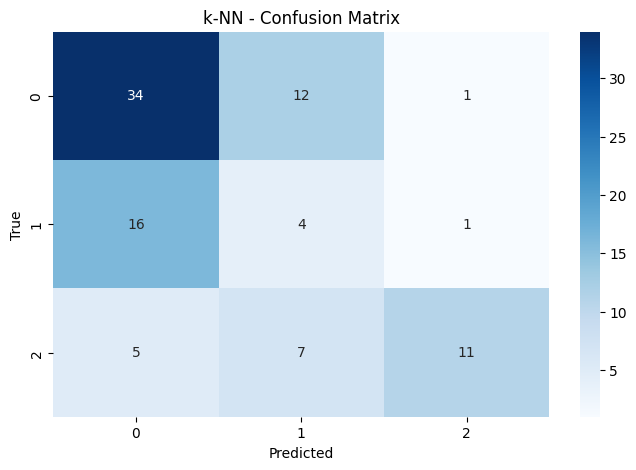

In [274]:

# Plot Confusion Matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("k-NN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

In [276]:
# Hypertune the model
param_grid = {
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_knn.fit(X_train, y_train)

print("Best Params:", grid_knn.best_params_)
print("Best CV Score:", grid_knn.best_score_)

Best Params: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Best CV Score: 0.7008751902587519


In [277]:
# Retrieve best estimator
best_knn = grid_knn.best_estimator_

# Evaluate on training data
train_accuracy = best_knn.score(X_train, y_train)

# Evaluate on test data
test_accuracy = best_knn.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

Training Accuracy: 0.7368
Test Accuracy:     0.5714


Text(70.72222222222221, 0.5, 'True')

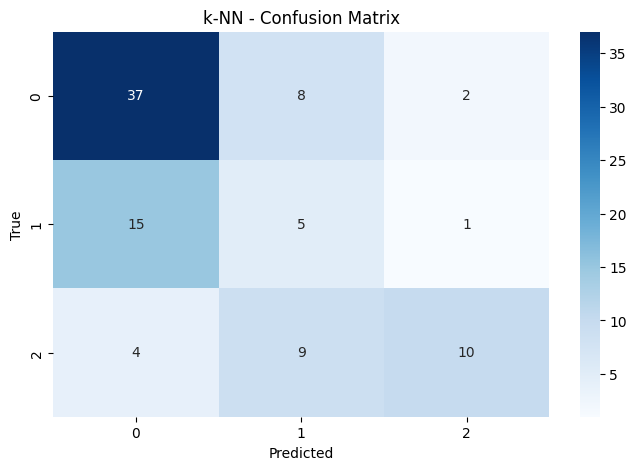

In [278]:
# Plot confusin matrix with best model
y_test_pred = best_knn.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("k-NN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")